In [40]:
import pandas as pd
import sys
import os
import random

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [41]:
import warnings

warnings.filterwarnings("ignore")

In [42]:
sys.path.append('../')
from feature_engineering import feature_engineering
from data_loader import lgbm_data_loader

In [43]:
IS_CUSTOM = True
USE_VALID = True
valid_len = 1
DROPS = [
    'assessmentItemID','testId','Timestamp','year','day','minute','second',
]

In [44]:
train, valid, y_train, y_valid, test = lgbm_data_loader(IS_CUSTOM=IS_CUSTOM,USE_VALID=USE_VALID, DROPS=DROPS, valid_len=valid_len)
lgb_train = lgb.Dataset(train, y_train)
lgb_valid = lgb.Dataset(valid, y_valid)

In [45]:
train.shape, valid.shape, test.shape

((2471510, 47), (3720, 47), (744, 48))

## 1. 데이터 로딩

## 2. Feature Engineering

## 3. Train/Test 데이터 셋 분리

In [46]:
# # train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
# random.seed(42)


# def custom_train_test_split(df, ratio=0.7, split=True):

#     users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
#     random.shuffle(users)

#     max_train_data_len = ratio * len(df)
#     sum_of_train_data = 0
#     user_ids = []

#     for user_id, count in users:
#         sum_of_train_data += count
#         if max_train_data_len < sum_of_train_data:
#             break
#         user_ids.append(user_id)

#     train = df[df["userID"].isin(user_ids)]
#     test = df[df["userID"].isin(user_ids) == False]

#     # test데이터셋은 각 유저의 마지막 interaction만 추출
#     test = test[test["userID"] != test["userID"].shift(-1)]
#     return train, test
# 유저별 분리
# train, test = custom_train_test_split(df)

# X, y 값 분리

## 4. 훈련 및 검증

In [47]:
"""
{'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.1, 'n_iter': 200, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.75, 'num_leaves': 400}
"""
params = {
    "objective": "binary",
    "bagging_fraction": 0.62,
    "bagging_seed": 11,
    "learning_rate": 0.1,
    "num_iterations": 1000,
    "max_depth": -1,
    "boosting": "gbdt",
    "early_stopping": 35,
    "feature_fraction": 0.75,
    "num_leaves": 400,
    "min_child_weight": 0.03454472573214212,
    "reg_alpha": 0.3899927210061127,
    "reg_lambda": 0.6485237330340494,
    "random_state": 47,
    "metric": "auc",
    "verbosity": -1,
}
valid_sets = [lgb_train, lgb_valid] if USE_VALID else [lgb_train]
model = lgb.train(
    params,
    lgb_valid,
    valid_sets=valid_sets,
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100,
)

Training until validation scores don't improve for 35 rounds
Early stopping, best iteration is:
[18]	training's auc: 0.962796	valid_0's auc: 0.756455


In [48]:
preds = model.predict(valid)
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

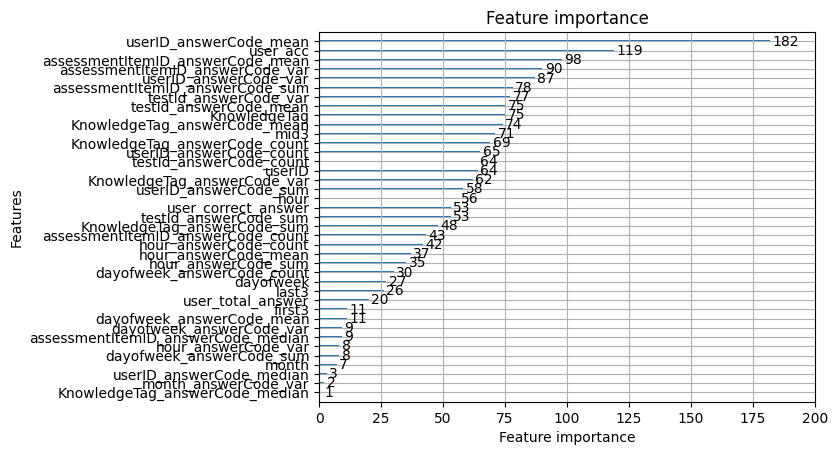

In [49]:
_ = lgb.plot_importance(model)

## 5. Inference

In [50]:
# LOAD TESTDATA

# FEATURE ENGINEERING

# LEAVE LAST INTERACTION ONLY

# DROP ANSWERCODE
test_df = test.drop(["answerCode"], axis=1)

In [51]:
# MAKE PREDICTION
total_preds = model.predict(test_df)

In [52]:
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "lgbm_submission.csv")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : output/lgbm_submission.csv


### Optuna example

In [53]:
# {'bagging_fraction': 0.61, 'seed': 11, 'lr': 0.1, 'n_iter': 1000, 'max_depth': 2, 'patience': 35, 'feature_fraction': 0.56, 'num_leaves': 150}

In [54]:
def objective(trial: Trial):
    params = {
        'objective': 'binary',
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 0.8, step=0.01),
        'bagging_seed': trial.suggest_categorical("seed", [11, 42]), ##
        'learning_rate': trial.suggest_categorical("lr", [0.001, 0.005, 0.01, 0.05, 0.1]),
        'num_iterations': trial.suggest_int("n_iter", 100, 1500, 100),
        'max_depth': trial.suggest_categorical('max_depth', [-1, 1, 2]), # need to consider
        'boosting': 'gbdt',
        'early_stopping': trial.suggest_int('patience', 5, 40, 5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.8, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 100, 500, 50),
        'min_child_weight': 0.03454472573214212,
        'reg_alpha': 0.3899927210061127,
        'reg_lambda': 0.6485237330340494,
        'random_state': 47,
        "metric": 'auc',
        "verbosity": -1,
    }
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        verbose_eval=100,
        num_boost_round=500,
        early_stopping_rounds=100
    )

    preds = model.predict(valid)
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)

    return auc
if USE_VALID and IS_CUSTOM:
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
        study_name="lgbm_parameter_opt",
        direction="maximize",
        sampler=sampler,
    )
    study.optimize(objective, n_trials=10)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)

[I 2022-11-28 13:21:04,788] A new study created in memory with name: lgbm_parameter_opt


Training until validation scores don't improve for 35 rounds
[100]	training's auc: 0.794713	valid_1's auc: 0.788118
[200]	training's auc: 0.796886	valid_1's auc: 0.78941


[I 2022-11-28 13:21:56,791] Trial 0 finished with value: 0.7897261584892283 and parameters: {'bagging_fraction': 0.61, 'seed': 11, 'lr': 0.1, 'n_iter': 1000, 'max_depth': 2, 'patience': 35, 'feature_fraction': 0.56, 'num_leaves': 150}. Best is trial 0 with value: 0.7897261584892283.


Early stopping, best iteration is:
[237]	training's auc: 0.797427	valid_1's auc: 0.789726
Training until validation scores don't improve for 25 rounds


[I 2022-11-28 13:22:01,378] Trial 1 finished with value: 0.746090418101098 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 600, 'max_depth': 1, 'patience': 25, 'feature_fraction': 0.6799999999999999, 'num_leaves': 100}. Best is trial 0 with value: 0.7897261584892283.


Early stopping, best iteration is:
[15]	training's auc: 0.751737	valid_1's auc: 0.74609
Training until validation scores don't improve for 5 rounds


[I 2022-11-28 13:22:13,612] Trial 2 finished with value: 0.7681604548660301 and parameters: {'bagging_fraction': 0.6799999999999999, 'seed': 11, 'lr': 0.005, 'n_iter': 1100, 'max_depth': 2, 'patience': 5, 'feature_fraction': 0.78, 'num_leaves': 200}. Best is trial 0 with value: 0.7897261584892283.


Early stopping, best iteration is:
[86]	training's auc: 0.770568	valid_1's auc: 0.76816
Training until validation scores don't improve for 10 rounds


[I 2022-11-28 13:22:16,758] Trial 3 finished with value: 0.7452929932464283 and parameters: {'bagging_fraction': 0.7, 'seed': 42, 'lr': 0.01, 'n_iter': 1400, 'max_depth': 1, 'patience': 10, 'feature_fraction': 0.51, 'num_leaves': 200}. Best is trial 0 with value: 0.7897261584892283.


Early stopping, best iteration is:
[15]	training's auc: 0.753945	valid_1's auc: 0.745293
Training until validation scores don't improve for 5 rounds
[100]	training's auc: 0.834984	valid_1's auc: 0.825954


[I 2022-11-28 13:22:57,486] Trial 4 finished with value: 0.8321753774652013 and parameters: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.1, 'n_iter': 200, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.75, 'num_leaves': 400}. Best is trial 4 with value: 0.8321753774652013.


Early stopping, best iteration is:
[149]	training's auc: 0.843993	valid_1's auc: 0.832175
Training until validation scores don't improve for 30 rounds


[I 2022-11-28 13:23:11,871] Trial 5 finished with value: 0.7747863276793044 and parameters: {'bagging_fraction': 0.72, 'seed': 11, 'lr': 0.01, 'n_iter': 100, 'max_depth': 2, 'patience': 30, 'feature_fraction': 0.77, 'num_leaves': 300}. Best is trial 4 with value: 0.8321753774652013.


[100]	training's auc: 0.778348	valid_1's auc: 0.774786
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.778348	valid_1's auc: 0.774786
Training until validation scores don't improve for 15 rounds


[I 2022-11-28 13:23:15,660] Trial 6 finished with value: 0.7648970594208445 and parameters: {'bagging_fraction': 0.53, 'seed': 42, 'lr': 0.005, 'n_iter': 100, 'max_depth': 2, 'patience': 15, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 4 with value: 0.8321753774652013.


Early stopping, best iteration is:
[12]	training's auc: 0.768373	valid_1's auc: 0.764897
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.790593	valid_1's auc: 0.786993


[I 2022-11-28 13:23:38,176] Trial 7 finished with value: 0.7882957786177518 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.1, 'n_iter': 1300, 'max_depth': 1, 'patience': 10, 'feature_fraction': 0.77, 'num_leaves': 300}. Best is trial 4 with value: 0.8321753774652013.


Early stopping, best iteration is:
[147]	training's auc: 0.792587	valid_1's auc: 0.788296
Training until validation scores don't improve for 5 rounds


[I 2022-11-28 13:24:08,708] Trial 8 finished with value: 0.8247386945064306 and parameters: {'bagging_fraction': 0.75, 'seed': 11, 'lr': 0.1, 'n_iter': 100, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 4 with value: 0.8321753774652013.


[100]	training's auc: 0.839236	valid_1's auc: 0.824739
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.839236	valid_1's auc: 0.824739
Training until validation scores don't improve for 25 rounds


[I 2022-11-28 13:24:13,913] Trial 9 finished with value: 0.7690681929795843 and parameters: {'bagging_fraction': 0.6, 'seed': 42, 'lr': 0.005, 'n_iter': 500, 'max_depth': 2, 'patience': 25, 'feature_fraction': 0.51, 'num_leaves': 200}. Best is trial 4 with value: 0.8321753774652013.


Early stopping, best iteration is:
[12]	training's auc: 0.77133	valid_1's auc: 0.769068
Best Score: 0.8321753774652013
Best trial: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.1, 'n_iter': 200, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.75, 'num_leaves': 400}
